<a href="https://colab.research.google.com/github/Aidin-Poorsolhjouy/DT2/blob/main/02_DT2_PDM_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook focuses on developing and evaluating an XGBoost model for predictive maintenance using the AI4I 2020 Predictive Maintenance Dataset.

The notebook implements a modular approach, encapsulating data preprocessing, model training, and evaluation within reusable functions. This is for easy experimentation with different *preprocessing techniques*, *feature sets*, and *model parameters*.

The notebook includes data preprocessing steps such as
- train/test splitting
- type encoding
- feature scaling
- oversampling to address class imbalance.

It also provides visualizations of the *learning curve* and *feature importance* to gain insights into the model's behavior and identify key factors influencing machine failures.

##Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, matthews_corrcoef
from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from sklearn.inspection import permutation_importance
import time
import warnings
warnings.filterwarnings("ignore")

## Importing Dataset and Creating new features

In [ ]:
df = pd.read_csv('ai4i2020.csv')
df.rename(columns={'Air temperature [K]': 'Air temperature K', 'Process temperature [K]': 'Process temperature K'
, 'Rotational speed [rpm]': 'Rotational speed rpm', 'Torque [Nm]' : 'Torque Nm', 'Tool wear [min]': 'Tool wear min'}, inplace=True)
# with int type, the scaler transformer gives warning
df['Rotational speed rpm'] = df['Rotational speed rpm'].astype(float)
df['Tool wear min'] = df['Tool wear min'].astype(float)

df['dt']=df['Process temperature K']-df['Air temperature K']
df['power']=df['Torque Nm']*df['Rotational speed rpm']
df['strain']=df['Torque Nm']*df['Tool wear min']


# Define scalings
scalings = {
     "Air temperature K": "standard",
     "Process temperature K": "standard",
     "Rotational speed rpm": "log",
     "Torque Nm": "standard",
     "Tool wear min": "minmax", #minmax
     "dt": "standard",
     "power": "standard",
     "strain": "log" #log
 }
scalingsstd = {
     "Air temperature K": "standard",
     "Process temperature K": "standard",
     "Rotational speed rpm": "standard",
     "Torque Nm": "standard",
     "Tool wear min": "standard", #minmax
     "dt": "standard",
     "power": "standard",
     "strain": "standard" #log
 }

# Functions

##Preprocessing Function

In [ ]:
def preprocess_data(df, features, target, test_size=0.2, val_size = 0.2, manual_tune = True, random_state=42, scalings=None, oversampling=None):
    """
    Preprocesses the data, including train/test split, type encoding, scaling, and oversampling.

    Args:
        df (pd.DataFrame): The input DataFrame.
        features (list): List of feature names.
        target (str): The name of the target variable.
        test_size (float): The proportion of the data to use for testing.
        random_state (int): Random state for reproducibility.
        scalings (dict): Dictionary of scaling methods for each feature.
        oversampling (str): Oversampling method ('smote', 'svmsmote', 'randomoversampler', or None).

    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """

    # Create copies to avoid modifying the original DataFrame
    df = df.copy()

    if manual_tune:

      # Split into train (60%), validation (20%), and test (20%) before any analysis.
      # use stratify over the machine failure, to have the same distribution in the sets.
      df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])
      df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42, stratify=df_train[target])
    else:
      # Train/Test Split
      df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target])

    # Type Encoding
    df_train['Type'] = df_train['Type'].replace({'L': 0, 'M': 1, 'H': 2})
    df_test['Type'] = df_test['Type'].replace({'L': 0, 'M': 1, 'H': 2})
    if manual_tune:
      df_val['Type'] = df_val['Type'].replace({'L': 0, 'M': 1, 'H': 2})

    # Separate features and target
    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]
    y_test = df_test[target]
    X_val = None
    y_val = None

    if manual_tune:
      X_val = df_val[features]
      y_val = df_val[target]

    # Imputation
    # Create separate imputers for 'Rotational speed rpm' and other numerical features
    imputer_rotational_speed = SimpleImputer(strategy='median')
    imputer_other = SimpleImputer(strategy='mean')

    # Impute 'Rotational speed rpm'
    X_train['Rotational speed rpm'] = imputer_rotational_speed.fit_transform(X_train[['Rotational speed rpm']])
    X_test['Rotational speed rpm'] = imputer_rotational_speed.transform(X_test[['Rotational speed rpm']])
    if manual_tune:
      X_val['Rotational speed rpm'] = imputer_rotational_speed.transform(X_val[['Rotational speed rpm']])

    # Impute other numerical features
    numerical_features_to_impute = [f for f in features if f != 'Rotational speed rpm']
    X_train[numerical_features_to_impute] = imputer_other.fit_transform(X_train[numerical_features_to_impute])
    X_test[numerical_features_to_impute] = imputer_other.transform(X_test[numerical_features_to_impute])

    if manual_tune:
      X_val[numerical_features_to_impute] = imputer_other.transform(X_val[numerical_features_to_impute])

    # Oversampling
    if oversampling == "smote":
        oversampler = SMOTE(random_state=random_state)
    elif oversampling == "svmsmote":
        oversampler = SVMSMOTE(random_state=random_state)
    elif oversampling == "randomoversampler":
        oversampler = RandomOverSampler(random_state=random_state)
    else:
        oversampler = None

    if oversampling:
        X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # Scaling
    if scalings:
        scalers = {
            "standard": StandardScaler(),
            "minmax": MinMaxScaler(),
            "log": FunctionTransformer(np.log1p)  # log1p to handle zero values safely
        }
        for feature in features:
            if feature in scalings:
                scaler = scalers[scalings[feature]]
                X_train.loc[:, feature] = scaler.fit_transform(X_train[[feature]])
                X_test.loc[:, feature] = scaler.transform(X_test[[feature]])
                if manual_tune:
                  X_val.loc[:, feature] = scaler.transform(X_val[[feature]])

    return X_train, X_val, X_test, y_train, y_val, y_test

## XGBoost Model Training

In [ ]:
def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, X_val=None, y_val = None, randomized_search=False, random_state=42, cv=5, n_iter=10,
                           n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1,
                           gamma=0, subsample=1.0, colsample_bytree=1.0, reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1):
    """
    Trains and evaluates an XGBoost model, with or without Randomized Search.

    Args:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target.
        y_test (pd.Series): Testing target.
        randomized_search (bool): Whether to perform Randomized Search.
        random_state (int): Random state for reproducibility.
        cv (int): Number of cross-validation folds.
        n_iter (int): Number of iterations for Randomized Search.
        n_estimators (int): Number of boosting rounds (if randomized_search is False).
        learning_rate (float): Step size shrinkage to prevent overfitting (if randomized_search is False).
        max_depth (int): Maximum depth of a tree (if randomized_search is False).
        min_child_weight (int): Minimum sum of instance weight (Hessian) needed in a child (if randomized_search is False).
        gamma (float): Minimum loss reduction required to make a further partition on a leaf node (if randomized_search is False).
        subsample (float): Subsample ratio of the training instance (if randomized_search is False).
        colsample_bytree (float): Subsample ratio of columns when constructing each tree (if randomized_search is False).
        reg_alpha (float): L1 regularization term on weights (if randomized_search is False).
        reg_lambda (float): L2 regularization term on weights (if randomized_search is False).
        scale_pos_weight (float): Controls the balance of positive and negative weights (if randomized_search is False).

    Returns:
        tuple: (trained model, dictionary of evaluation metrics, training time, inference time)
    """

    # Define the parameter distribution for XGBoost
    param_distributions = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6, 7],
        #'min_child_weight': [1, 3, 5, 7],
        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
        #'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        #'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0.0, 0.001, 0.01, 0.1, 1],
        'reg_lambda': [1, 1.5, 2, 2.5, 3],
        #'scale_pos_weight': [1, 2, 3, 4, 5]
    }

    # Initialize XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)

    # Perform Randomized Search
    best_estimators = []
    if randomized_search:
        print("Performing Randomized Search...")
        start_time = time.time()
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
        random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,
                                              n_iter=n_iter, scoring='f1', cv=skf, n_jobs=-1, verbose=1, random_state=random_state)
        random_search_xgb.fit(X_train, y_train)
        training_time = time.time() - start_time

        print("Best parameters found:", random_search_xgb.best_params_)
        xgb_model = random_search_xgb.best_estimator_

        # Get the results as a DataFrame
        results_df = pd.DataFrame(random_search_xgb.cv_results_)

        # Sort by the mean test score (validation score)
        results_df = results_df.sort_values(by='mean_test_score', ascending=False)

        # Select the top 5 models
        top_5_models = results_df.head(5)

        # Print the best parameters and scores for the top 5 models
        print("Next 4 Models:")
        for i in range(4):
            print(f"\nModel {i+2}:")
            print(f"  Parameters: {top_5_models['params'].iloc[i+1]}")

        # Access the actual trained models (estimators)
        for i in range(5):
            best_estimators.append(random_search_xgb.estimator.set_params(**top_5_models['params'].iloc[i]))
    else:
        print("Training XGBoost without Randomized Search...")
        start_time = time.time()
        xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state,
                                  n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
                                  min_child_weight=min_child_weight, gamma=gamma, subsample=subsample,
                                  colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                  scale_pos_weight=scale_pos_weight)
        xgb_model.fit(X_train, y_train)
        training_time = time.time() - start_time

    # Make predictions
    start_time = time.time()
    y_pred = xgb_model.predict(X_test)
    inference_time = time.time() - start_time

    # Evaluate the model
    metrics = {
        #"accuracy": accuracy_score(y_test, y_pred),
        #"balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        #"precision": precision_score(y_test, y_pred),
        #"recall": recall_score(y_test, y_pred),
        #"f1_score": f1_score(y_test, y_pred),
        #"roc_auc": roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]),
        "mcc": matthews_corrcoef(y_test, y_pred),
        "training_time": training_time,
        "inference_time": inference_time
    }

    return xgb_model, metrics, best_estimators

##Learning Curve Function

In [ ]:
def plot_learning_curve(model, X_train, y_train, scoring="f1", cv=5):
    """
    Plots the learning curve for a given model.

    Args:
        model: Trained model.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        scoring (str): Scoring metric for learning curve.
        cv (int): Number of cross-validation folds.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=skf, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and std for train and validation scores
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(5, 3))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, val_mean, label="Validation score", color="green")
    plt.title("Learning Curve for XGBoost")
    plt.xlabel("Training Size")
    plt.ylabel("F1")
    plt.legend()
    plt.show()

## Feature Importance Function

In [ ]:
def plot_feature_importance(model, X_train):
    """
    Plots the feature importance for a given model.

    Args:
        model: Trained model.
        X_train (pd.DataFrame): Training features.
    """
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(5, 3))
    sns.barplot(x='importance', y='feature', data=feature_importances)
    plt.title('Feature Importances (XGBoost)')
    plt.show()

## Confusion Matrix Function

In [ ]:
def plot_confusion_matrix(cm):
  # Plot the confusion matrix as a heatmap
  plt.figure(figsize=(2, 2))  # Adjust figure size as needed
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)  # Customize the heatmap
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.show()

#Apply ML

## Tier 1 - Variations in features, w/wo scaling, w/wo oversampling

All basic features | Without Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.91      0.60      0.73        68

    accuracy                           0.98      2000
   macro avg       0.95      0.80      0.86      2000
weighted avg       0.98      0.98      0.98      2000



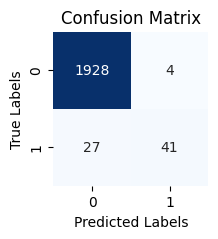

mcc: 0.73
training_time: 1.25
inference_time: 0.01


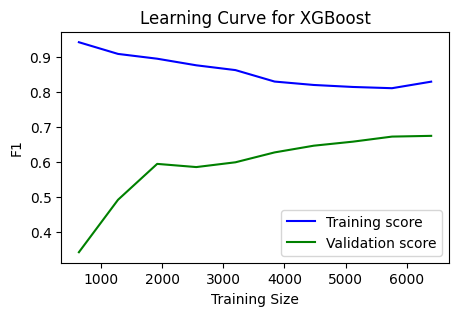

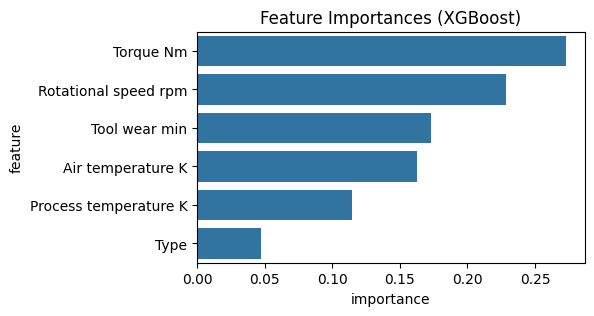

In [ ]:
print('All basic features | Without Scaling | Without Oversampling')
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features, wo Type | Without Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.86      0.63      0.73        68

    accuracy                           0.98      2000
   macro avg       0.92      0.81      0.86      2000
weighted avg       0.98      0.98      0.98      2000



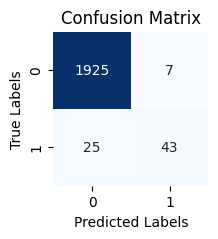

mcc: 0.73
training_time: 0.07
inference_time: 0.01


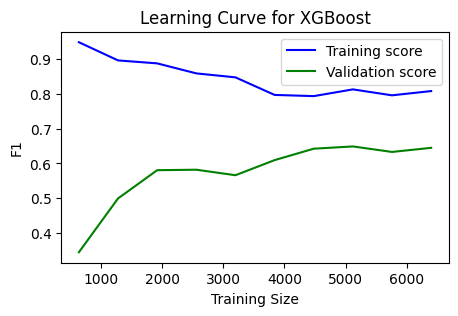

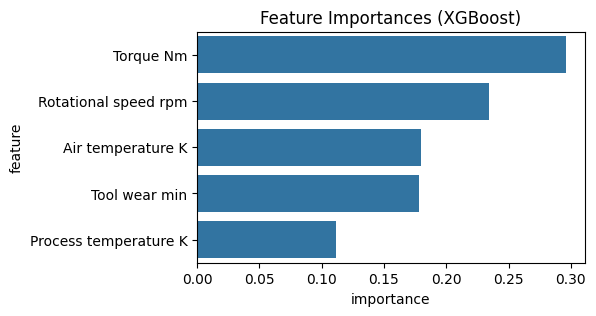

In [ ]:
print('All basic features, wo Type | Without Scaling | Without Oversampling')
# Define features and target
features = [ 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features, wo Type, AT, & PT | Without Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.87      0.38      0.53        68

    accuracy                           0.98      2000
   macro avg       0.92      0.69      0.76      2000
weighted avg       0.97      0.98      0.97      2000

mcc: 0.57
training_time: 0.13
inference_time: 0.01


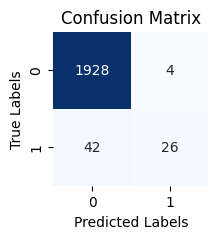

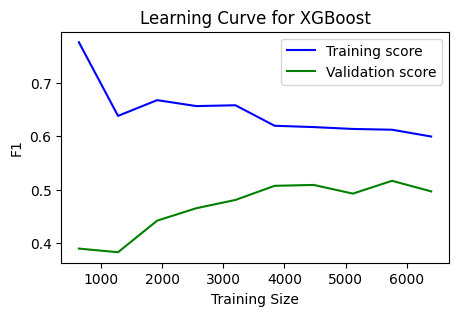

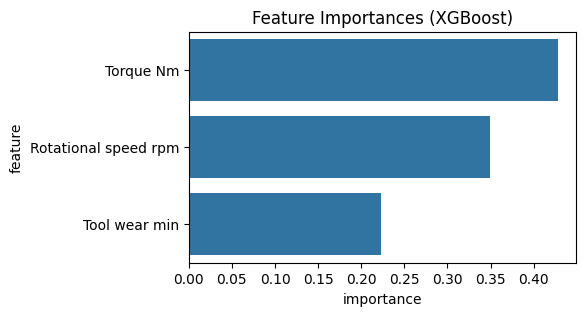

In [ ]:
print('All basic features, wo Type, AT, & PT | Without Scaling | Without Oversampling')
# Define features and target
features = [ 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features | With Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.91      0.60      0.73        68

    accuracy                           0.98      2000
   macro avg       0.95      0.80      0.86      2000
weighted avg       0.98      0.98      0.98      2000



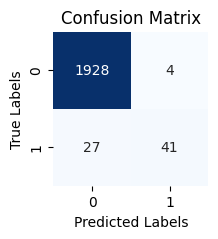

mcc: 0.73
training_time: 0.97
inference_time: 0.04


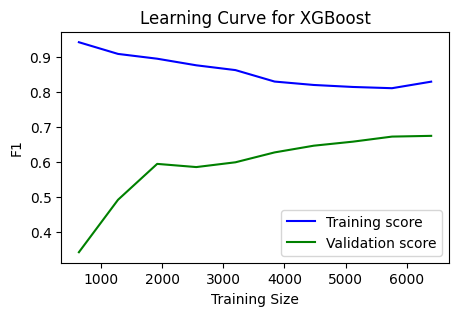

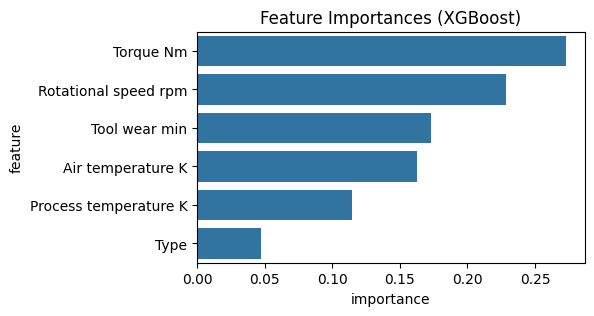

In [ ]:
print('All basic features | With Scaling | Without Oversampling')
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features | Without Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.95      0.78      0.85        68

    accuracy                           0.99      2000
   macro avg       0.97      0.89      0.93      2000
weighted avg       0.99      0.99      0.99      2000



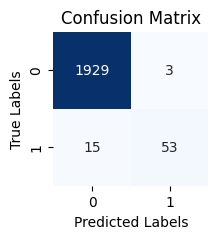

mcc: 0.85
training_time: 0.50
inference_time: 0.01


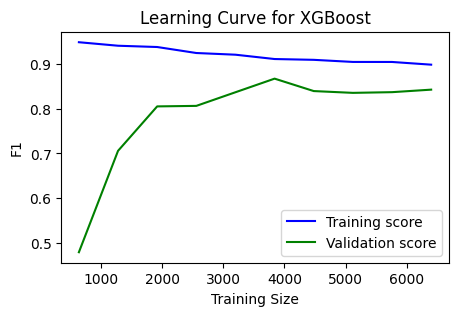

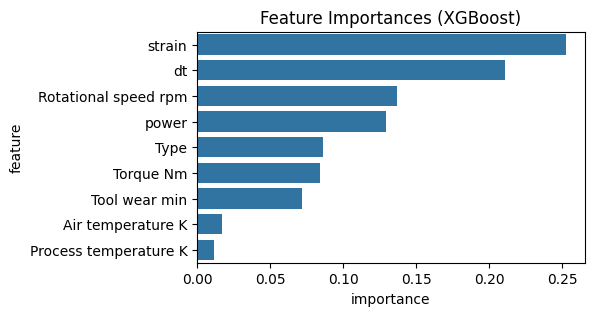

In [ ]:
print('All basic features | Without Scaling | Without Oversampling')
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features | With Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.95      0.78      0.85        68

    accuracy                           0.99      2000
   macro avg       0.97      0.89      0.93      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.85
training_time: 1.72
inference_time: 0.06


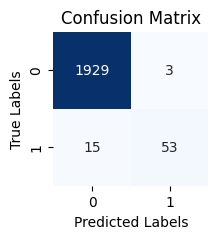

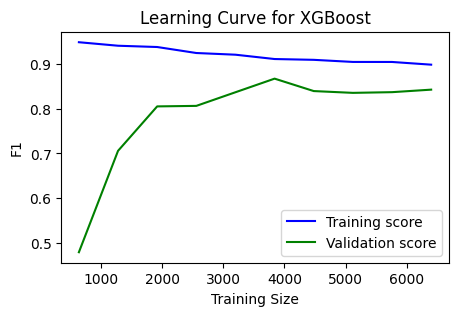

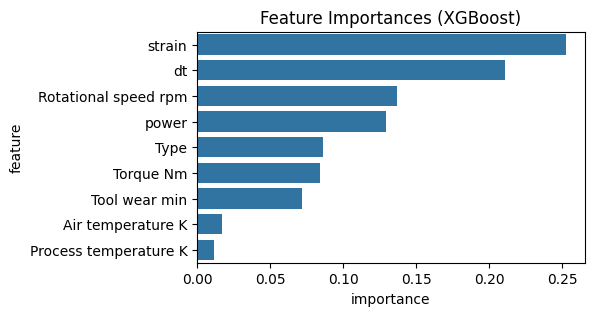

In [ ]:
print('All basic features | With Scaling | Without Oversampling')
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features, wo AT & PT | With Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.96      0.81      0.88        68

    accuracy                           0.99      2000
   macro avg       0.98      0.90      0.94      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.88
training_time: 0.18
inference_time: 0.01


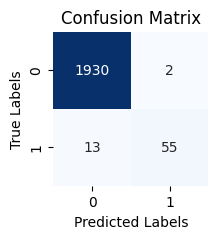

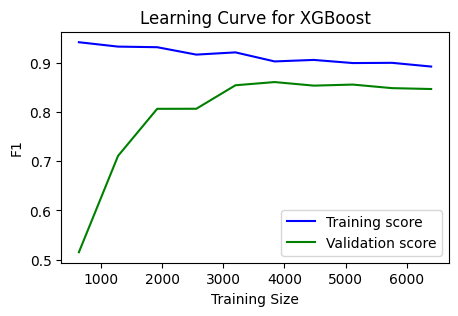

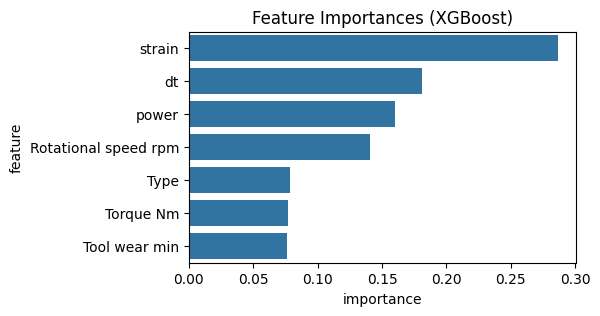

In [ ]:
print('All basic features, wo AT & PT | Without Scaling | Without Oversampling')
# Define features and target
features = ['Type',  'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features, wo Type | With Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.90      0.78      0.83        68

    accuracy                           0.99      2000
   macro avg       0.95      0.89      0.91      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.83
training_time: 0.29
inference_time: 0.03


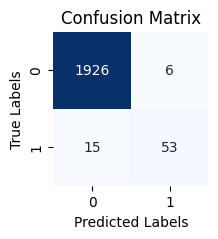

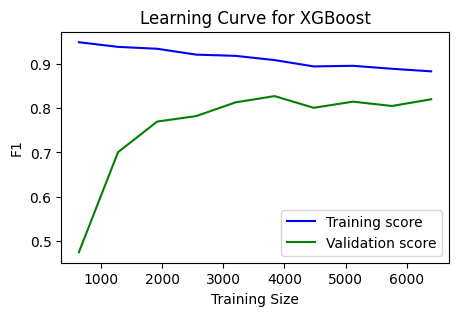

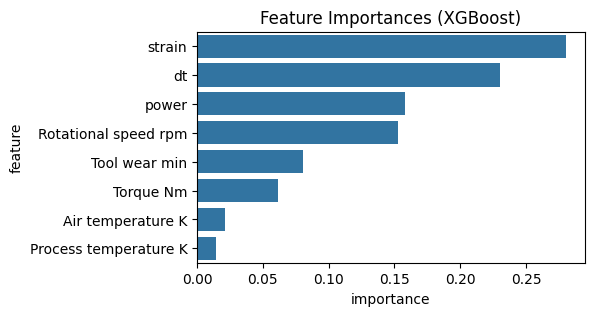

In [ ]:
print('All basic features, wo Type | Without Scaling | Without Oversampling')
# Define features and target
features = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features, wo Type, AT, & PT | With Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.92      0.81      0.86        68

    accuracy                           0.99      2000
   macro avg       0.95      0.90      0.93      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.86
training_time: 0.31
inference_time: 0.01


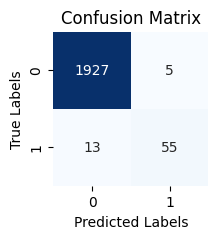

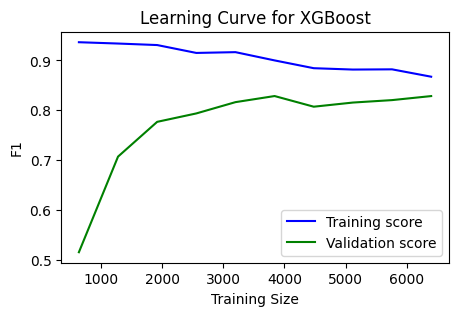

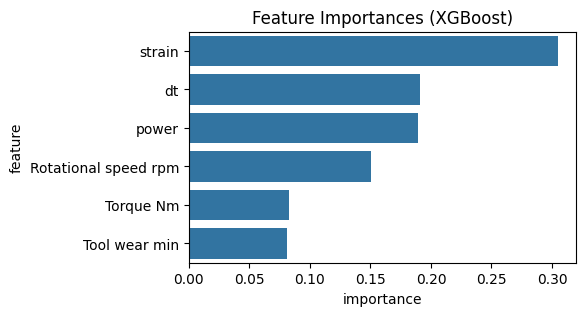

In [ ]:
print('All basic features, wo Type, AT, & PT | Without Scaling | Without Oversampling')
# Define features and target
features = ['Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features | With Scaling | Without Oversampling
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1932
           1       0.37      0.88      0.52        68

    accuracy                           0.94      2000
   macro avg       0.68      0.91      0.75      2000
weighted avg       0.97      0.94      0.96      2000

mcc: 0.55
training_time: 3.04
inference_time: 0.03


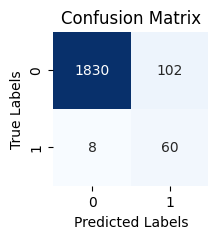

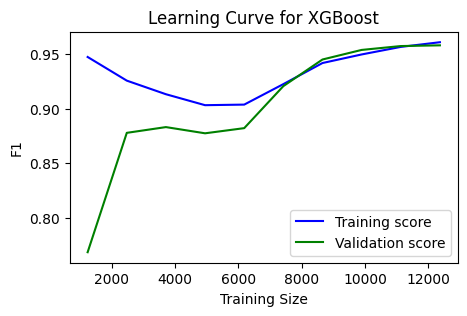

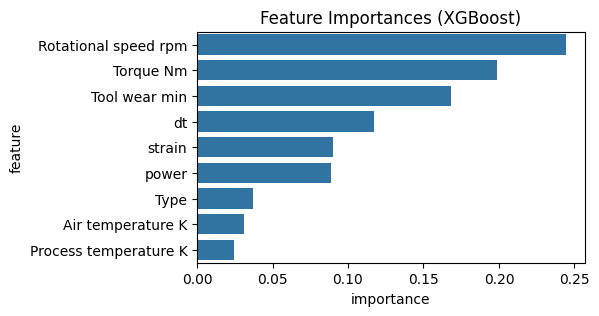

In [ ]:
print('All basic features | Without Scaling | Smote')
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling='smote')

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features | Without Scaling | SVMSmote
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1932
           1       0.44      0.87      0.58        68

    accuracy                           0.96      2000
   macro avg       0.72      0.91      0.78      2000
weighted avg       0.98      0.96      0.96      2000

mcc: 0.60
training_time: 0.80
inference_time: 0.01


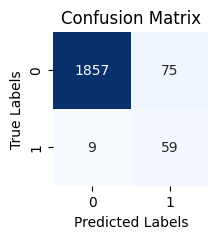

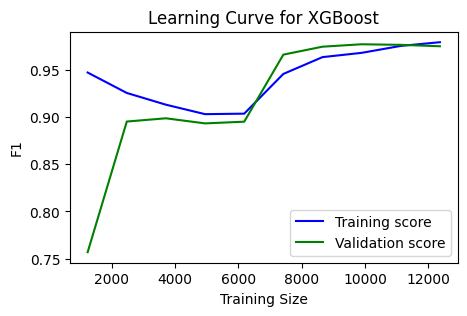

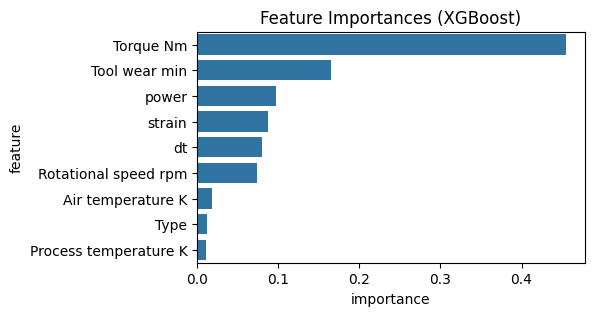

In [ ]:
print('All basic features | Without Scaling | SVMSmote')
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling='svmsmote')

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features | Without Scaling | Random oversampler
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1932
           1       0.46      0.90      0.61        68

    accuracy                           0.96      2000
   macro avg       0.73      0.93      0.79      2000
weighted avg       0.98      0.96      0.97      2000

mcc: 0.63
training_time: 0.34
inference_time: 0.01


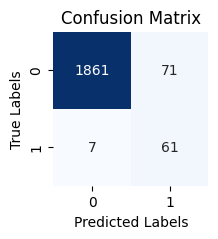

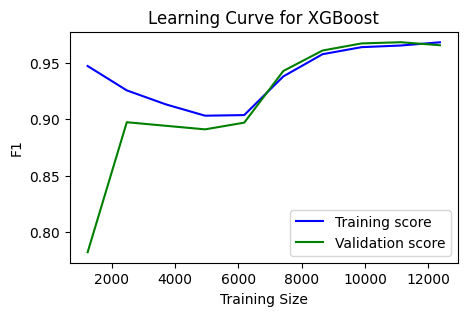

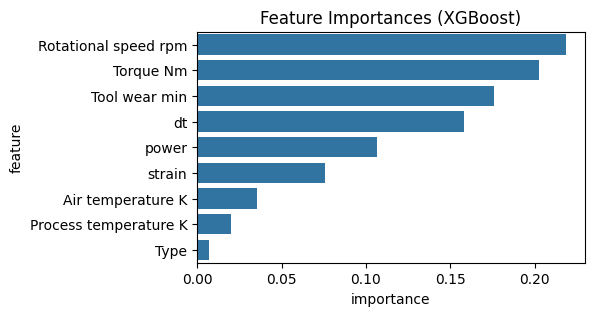

In [ ]:
print('All basic features | Without Scaling | Random oversampler')
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling='randomoversampler')

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features + dt,power, strain | Witt Scaling | Random oversampler
Training XGBoost without Randomized Search...

🔹 XGBoost
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1932
           1       0.46      0.90      0.61        68

    accuracy                           0.96      2000
   macro avg       0.73      0.93      0.79      2000
weighted avg       0.98      0.96      0.97      2000

mcc: 0.63
training_time: 0.63
inference_time: 0.04


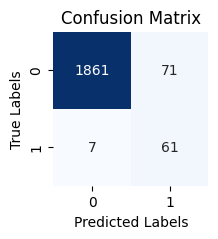

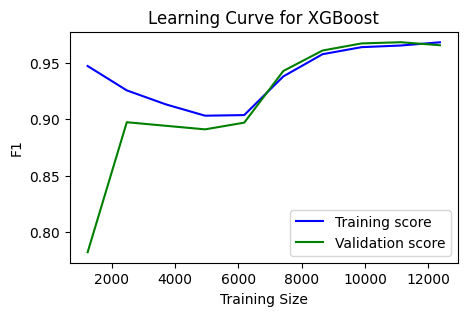

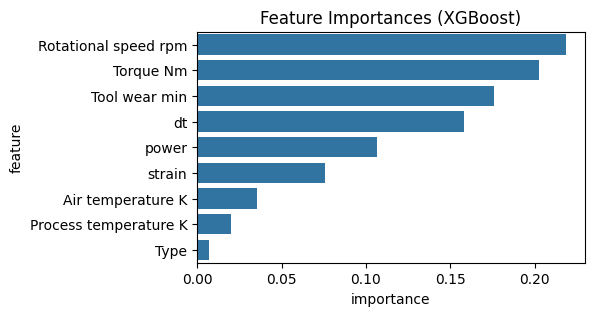

In [ ]:
print('All basic features + dt,power, strain | Witt Scaling | Random oversampler')
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling='randomoversampler')

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, X_train)

All basic features + dt,power, strain | Witt Scaling | no oversampling | Hyperparameter tuning
Performing Randomized Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'reg_lambda': 2.5, 'reg_alpha': 0.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.2}
Next 4 Models:

Model 2:
  Parameters: {'reg_lambda': 1.5, 'reg_alpha': 0.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.2}

Model 3:
  Parameters: {'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2}

Model 4:
  Parameters: {'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3}

Model 5:
  Parameters: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.3, 'gamma': 0.3}

🔹 XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
      

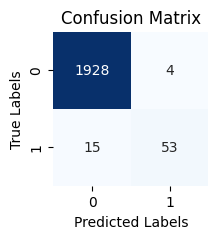

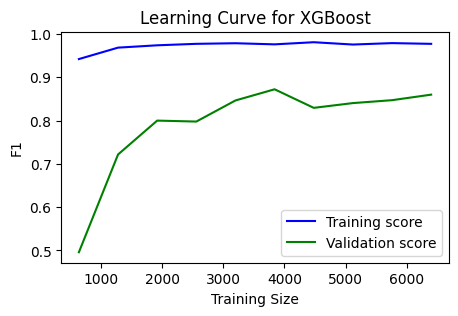


Model 2:
  Precision: 0.93
  Recall: 0.79
  F1-Score: 0.86
  MCC: 0.86


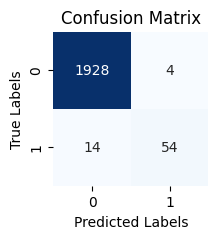

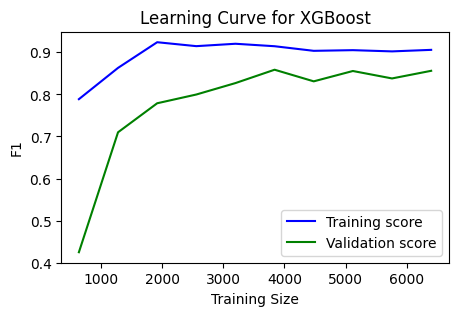


Model 3:
  Precision: 0.93
  Recall: 0.79
  F1-Score: 0.86
  MCC: 0.86


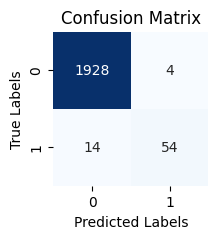

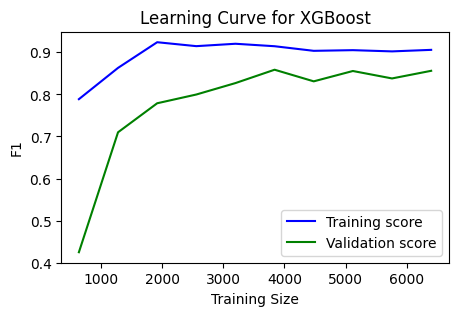


Model 4:
  Precision: 0.93
  Recall: 0.79
  F1-Score: 0.86
  MCC: 0.86


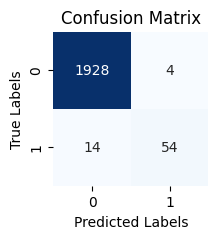

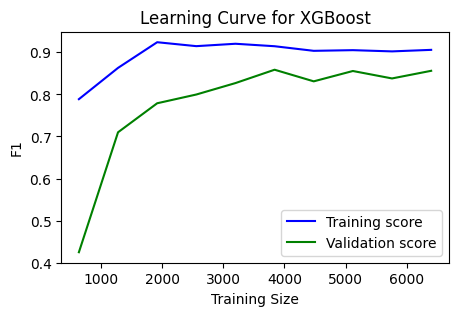


Model 5:
  Precision: 0.93
  Recall: 0.79
  F1-Score: 0.86
  MCC: 0.86


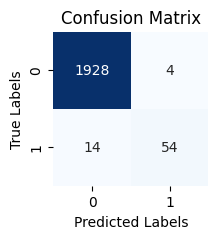

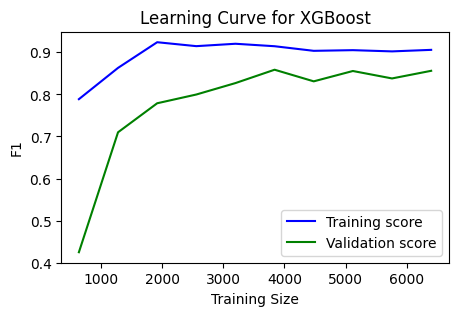

In [ ]:
print('All basic features + dt,power, strain | Witt Scaling | no oversampling | Hyperparameter tuning')
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_val, X_test, y_train,y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None, manual_tune=False)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=True, n_iter=20)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)

# Plot learning curves and confusion matrices for the top 3 models
for i, estimator in enumerate(best_estimators):
  if i>0:
    estimator.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = estimator.predict(X_test)

    # Calculate evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Print the evaluation metrics
    print(f"\nModel {i+1}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1-Score: {f1:.2f}")
    print(f"  MCC: {mcc:.2f}")

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot Learning Curve & Confusion Matrix
    plot_confusion_matrix(cm)
    plot_learning_curve(estimator, X_train, y_train, scoring='f1', cv=5)

All basic features, wo AT & PT + dt,power, strain | Witt Scaling | no oversampling | Hyperparameter tuning
Performing Randomized Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'subsample': 1.0, 'scale_pos_weight': 4, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 1.0}
Next 4 Models:

Model 2:
  Parameters: {'subsample': 0.8, 'scale_pos_weight': 3, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}

Model 3:
  Parameters: {'subsample': 0.8, 'scale_pos_weight': 4, 'reg_lambda': 3, 'reg_alpha': 0.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}

Model 4:
  Parameters: {'subsample': 1.0, 'scale_pos_weight': 5, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300

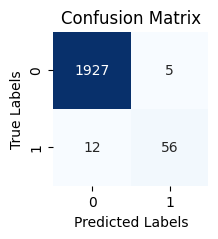

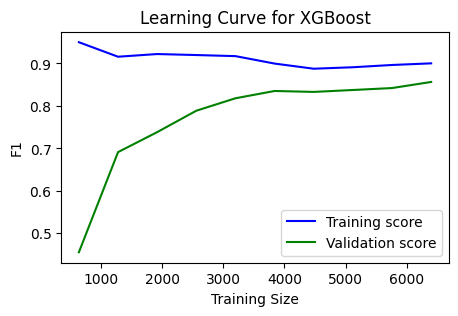


Model 2:
  Precision: 0.90
  Recall: 0.76
  F1-Score: 0.83
  MCC: 0.82


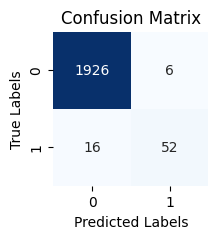

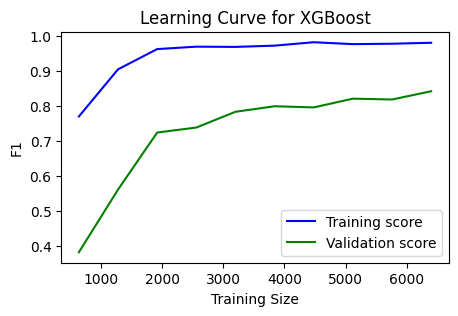


Model 3:
  Precision: 0.90
  Recall: 0.76
  F1-Score: 0.83
  MCC: 0.82


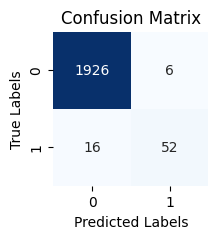

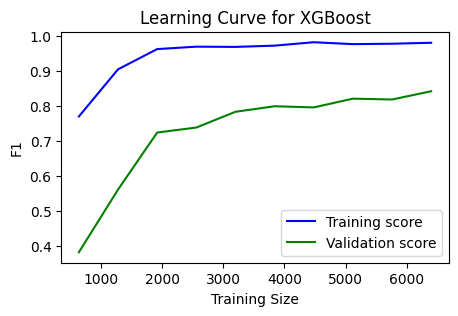


Model 4:
  Precision: 0.90
  Recall: 0.76
  F1-Score: 0.83
  MCC: 0.82


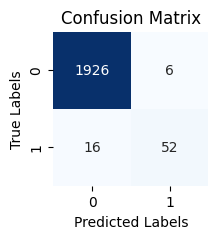

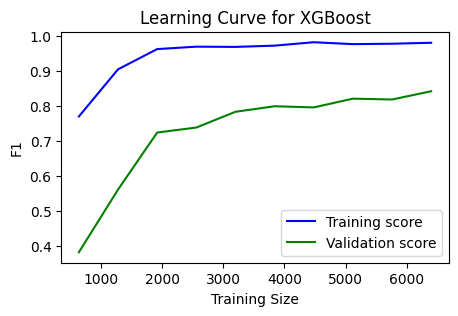


Model 5:
  Precision: 0.90
  Recall: 0.76
  F1-Score: 0.83
  MCC: 0.82


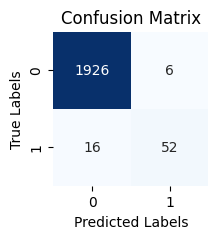

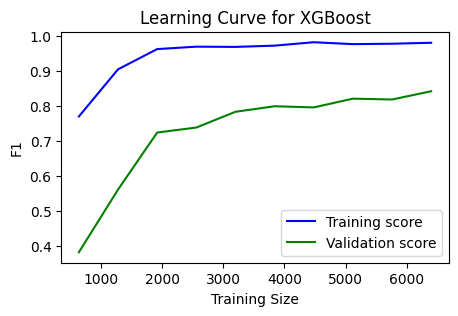

In [ ]:
print('All basic features, wo AT & PT + dt,power, strain | Witt Scaling | no oversampling | Hyperparameter tuning')
# Define features and target
features = ['Type',  'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Train and evaluate the XGBoost model with or without Randomized Search
## def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
## reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb_model, metrics, best_estimators = train_and_evaluate_xgb(X_train, X_test, y_train, y_test, randomized_search=True, n_iter=20)

# Print the evaluation metrics
print("\n🔹 XGBoost")
print(classification_report(y_test, xgb_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, xgb_model.predict(X_test)))

# Plot the learning curve and feature importance
plot_learning_curve(xgb_model, X_train, y_train)

# Plot learning curves and confusion matrices for the top 3 models
for i, estimator in enumerate(best_estimators):
  if i>0:
    estimator.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = estimator.predict(X_test)

    # Calculate evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Print the evaluation metrics
    print(f"\nModel {i+1}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1-Score: {f1:.2f}")
    print(f"  MCC: {mcc:.2f}")

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot Learning Curve & Confusion Matrix
    plot_confusion_matrix(cm)
    plot_learning_curve(estimator, X_train, y_train, scoring='f1', cv=5)

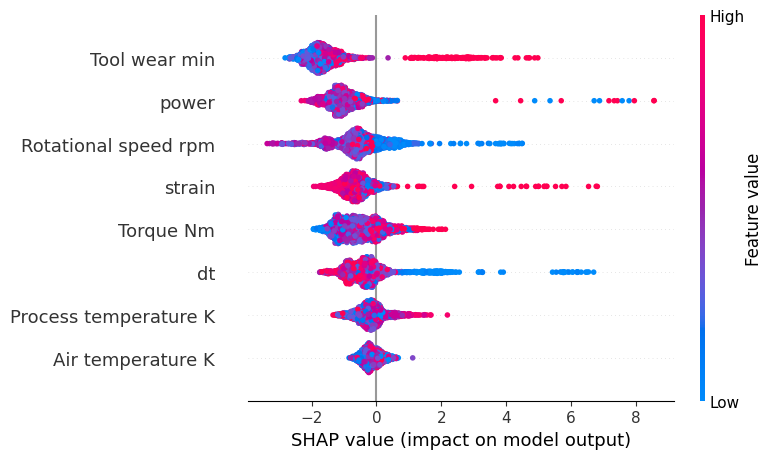

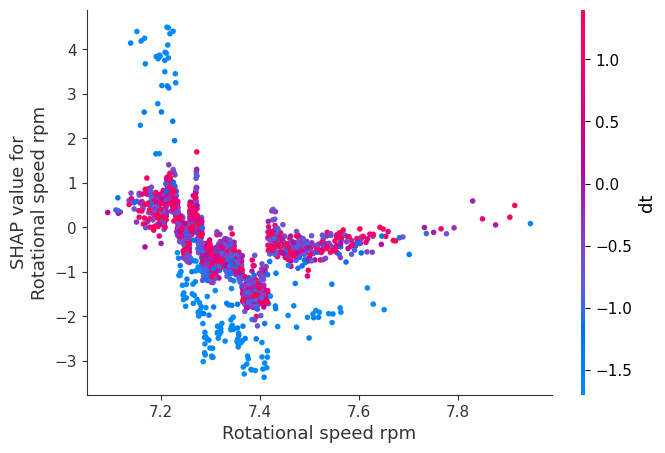

In [ ]:
import shap

# Load your data and train your XGBoost model (as you've already done)

# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_model)  # For tree-based models

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize feature importance based on SHAP values
shap.summary_plot(shap_values, X_test)

# Visualize the impact of a single feature
shap.dependence_plot("Rotational speed rpm", shap_values, X_test)